Decison Tree for Nighttime PM2.5 Prediction **without** Photographic Measurement

In [1]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

import scipy.io as sio
from scipy import stats
from scipy import ndimage
from scipy.interpolate import griddata
import math
import random

import time
import datetime
from datetime import date
from datetime import timedelta
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
from mpl_toolkits.basemap import Basemap

import xlrd 
import xlwt 
import xlsxwriter
import pathlib
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
#plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False 

def get_filename(filename):
  (filepath,tempfilename) = os.path.split(filename);
  (shotname,extension) = os.path.splitext(tempfilename);
  #return filepath, shotname, extension
  return shotname

def Normaltime(str_time_input):
    Normaltime_output = datetime.strptime(str_time_input,'%Y-%m-%d %H_%M')
    return Normaltime_output

def Changestr(datetime_input):
    str_output = datetime_input.strftime('%Y-%m-%d %H:%M')
    return str_output

def TS(x):
    return (x - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    #return datetime.utcfromtimestamp(x.astype('O')/1e9)
    #return datetime.fromtimestamp(x.tolist()/1e9)

def DT(x):
    return datetime.utcfromtimestamp(x)

def quantile_clip(group):
    group.plot()
    group[group < group.quantile(.02)] = group.quantile(.02)
    group[group > group.quantile(.98)] = group.quantile(.98)
    #group.plot()
    #plt.show()
    return group

def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

def excel_to_df(xlsx):
    df=pd.DataFrame(pd.read_excel(xlsx, sheet_name=get_filename(xlsx)))
    return df

In [3]:
file_PhotoRGB_AQI_Met = 'PhotoRGB_AQI_Met.xlsx'
PhotoRGB_AQI_Met=excel_to_df(file_PhotoRGB_AQI_Met)

In [4]:
PhotoRGB_AQI_Met['hr']=PhotoRGB_AQI_Met['Time'].dt.hour
PhotoRGB_AQI_Met['mnth']=PhotoRGB_AQI_Met['Time'].dt.month
print(PhotoRGB_AQI_Met['hr'].unique(),PhotoRGB_AQI_Met['mnth'].unique())

PhotoRGB_AQI_Met['hr_sin'] = np.sin(PhotoRGB_AQI_Met.hr*(2.*np.pi/24))
PhotoRGB_AQI_Met['hr_cos'] = np.cos(PhotoRGB_AQI_Met.hr*(2.*np.pi/24))
PhotoRGB_AQI_Met['mnth_sin'] = np.sin((PhotoRGB_AQI_Met.mnth-1)*(2.*np.pi/12))
PhotoRGB_AQI_Met['mnth_cos'] = np.cos((PhotoRGB_AQI_Met.mnth-1)*(2.*np.pi/12))

[11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3  4  5  6  7  8  9 10] [ 5  6  7  8  9 10 11 12  1  2  3]


In [5]:
print(PhotoRGB_AQI_Met.columns.values.tolist())

['Time', 'R_R_M', 'G_R_M', 'B_R_M', 'R_L_M', 'G_L_M', 'B_L_M', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'T2m', 'BLH', 'U10', 'V10', 'TP', 'SP', 'T_500', 'RH_500', 'U_500', 'V_500', 'GP_500', 'T_700', 'RH_700', 'U_700', 'V_700', 'GP_700', 'T_850', 'RH_850', 'U_850', 'V_850', 'GP_850', 'hr', 'mnth', 'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos']


In [6]:
PhotoRGB_AQI_Met.tail(10)

,Time,R_R_M,G_R_M,B_R_M,R_L_M,G_L_M,B_L_M,PM2.5,PM10,SO2,...,RH_850,U_850,V_850,GP_850,hr,mnth,hr_sin,hr_cos,mnth_sin,mnth_cos
6672,2020-03-03 00:00:00,14.151749,7.549884,4.846153,13.109260,13.510171,14.350148,50.0,33.0,3.0,...,62.496520,7.592054,-9.057551,14462.292835,0,3,0.000000,1.000000e+00,0.866025,0.5
6673,2020-03-03 01:00:00,8.262317,4.964623,3.016520,9.744970,10.836209,12.570807,59.0,42.0,3.0,...,38.068176,7.839909,-11.098263,14461.407271,1,3,0.258819,9.659258e-01,0.866025,0.5
6674,2020-03-03 02:00:00,4.932580,4.031668,1.784300,11.101873,10.373760,10.848863,60.0,40.0,3.0,...,31.290180,8.818588,-11.125560,14442.810419,2,3,0.500000,8.660254e-01,0.866025,0.5
6675,2020-03-03 03:00:00,2.640645,4.012834,1.262349,6.981145,7.192411,7.021112,59.0,38.0,3.0,...,34.680271,9.606163,-11.844012,14441.924854,3,3,0.707107,7.071068e-01,0.866025,0.5
6676,2020-03-03 04:00:00,2.852172,3.999403,1.334869,9.580993,8.221080,7.288990,19.0,13.0,1.0,...,38.848991,10.504926,-12.796126,14387.905425,4,3,0.866025,5.000000e-01,0.866025,0.5
6677,2020-03-03 05:00:00,3.601720,3.976215,4.355814,9.890073,8.451694,8.066061,5.0,19.0,1.0,...,40.874297,10.333513,-14.433937,14388.790990,5,3,0.965926,2.588190e-01,0.866025,0.5
6678,2020-03-03 06:00:00,192.657215,205.233848,199.139229,58.996045,53.497840,49.829146,6.0,27.0,1.0,...,46.226267,7.728722,-13.099667,14400.303327,6,3,1.000000,6.123234e-17,0.866025,0.5
6679,2020-03-03 07:00:00,180.849761,204.627872,206.672048,105.765903,92.520492,71.519379,9.0,40.0,2.0,...,45.983493,6.109559,-14.508184,14457.865013,7,3,0.965926,-2.588190e-01,0.866025,0.5
6680,2020-03-03 08:00:00,158.286751,188.749436,200.155608,133.865688,120.273148,92.558180,9.0,40.0,2.0,...,42.404825,3.365809,-15.879257,14521.891038,8,3,0.866025,-5.000000e-01,0.866025,0.5
6681,2020-03-03 09:00:00,149.166447,183.679463,196.686148,149.023774,136.469500,104.698705,10.0,41.0,2.0,...,40.412811,1.417684,-16.778239,14564.430430,9,3,0.707107,-7.071068e-01,0.866025,0.5


In [7]:
Va_Phtoto=['R_R_M', 'G_R_M', 'B_R_M', 'R_L_M', 'G_L_M', 'B_L_M']

Va_AQI=[ 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO']

Va_Met_Ground=['T2m','BLH','SP','TP','U10', 'V10'] 
Va_Met_Levels=['T_500', 'U_500', 'V_500', 'T_700', 'U_700', 'V_700','T_850', 'U_850', 'V_850']

Va_GE=['GE_500','KE_850']

Va_Time=['hr_sin', 'hr_cos','mnth_sin', 'mnth_cos']

In [8]:
dfs=[PhotoRGB_AQI_Met]

for df in dfs:
    T_500=df['T_500']
    T_850=df['T_850']
    Ro_500=T_500.map(lambda x: 50000*29/(8314*(x+273.15)))
    Ro_850=T_850.map(lambda x: 85000*29/(8314*(x+273.15)))

    U_500=df['U_500']
    V_500=df['V_500']
    U_850=df['U_850']
    V_850=df['V_850']

    KE_500=0.5*Ro_500*(U_500**2+V_500**2)
    KE_850=0.5*Ro_850*(U_850**2+V_850**2)

    GP_500=df['GP_500']
    GP_850=df['GP_850']
    GE_500=Ro_500*GP_500
    GE_850=Ro_850*GP_850

    df['GE_500']=GE_500
    df['KE_500']=KE_500
    df['GE_850']=GE_850
    df['KE_850']=KE_850

In [9]:
dfs[0].tail()

,Time,R_R_M,G_R_M,B_R_M,R_L_M,G_L_M,B_L_M,PM2.5,PM10,SO2,...,hr,mnth,hr_sin,hr_cos,mnth_sin,mnth_cos,GE_500,KE_500,GE_850,KE_850
6677,2020-03-03 05:00:00,3.601720,3.976215,4.355814,9.890073,8.451694,8.066061,5.0,19.0,1.0,...,5,3,0.965926,2.588190e-01,0.866025,0.5,37740.229281,403.266279,16104.086166,176.342820
6678,2020-03-03 06:00:00,192.657215,205.233848,199.139229,58.996045,53.497840,49.829146,6.0,27.0,1.0,...,6,3,1.000000,6.123234e-17,0.866025,0.5,37843.871764,397.569418,16129.594798,129.557357
6679,2020-03-03 07:00:00,180.849761,204.627872,206.672048,105.765903,92.520492,71.519379,9.0,40.0,2.0,...,7,3,0.965926,-2.588190e-01,0.866025,0.5,37927.414607,350.886293,16218.361215,138.994895
6680,2020-03-03 08:00:00,158.286751,188.749436,200.155608,133.865688,120.273148,92.558180,9.0,40.0,2.0,...,8,3,0.866025,-5.000000e-01,0.866025,0.5,37981.123303,345.882447,16287.966988,147.761235
6681,2020-03-03 09:00:00,149.166447,183.679463,196.686148,149.023774,136.469500,104.698705,10.0,41.0,2.0,...,9,3,0.707107,-7.071068e-01,0.866025,0.5,38032.808982,343.118749,16333.368437,158.977115


In [10]:
dfs[0][Va_AQI].describe()

,PM2.5,PM10,SO2,NO2,O3,CO
count,6173.000000,6056.000000,6304.000000,6304.000000,5893.000000,6292.000000
mean,42.370484,63.265026,4.138801,41.205425,64.540302,0.761411
std,41.650156,46.867168,4.139514,26.236440,59.263504,0.542929
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000
25%,14.000000,29.000000,2.000000,21.000000,19.000000,0.400000
50%,31.000000,55.000000,3.000000,35.000000,51.000000,0.600000
75%,55.000000,84.000000,5.000000,58.000000,86.000000,1.000000
max,262.000000,574.000000,47.000000,173.000000,326.000000,3.600000


In [11]:
def getdata_day(df):
    va=df.columns.values.tolist()
    day=df[va][df['R_R_M'] > 100]
    return day

def getdata_night(df):
    va=df.columns.values.tolist()
    night=df[va][df['R_R_M'] <100]
    return night

In [12]:
R_B_Sky = dfs[0]['R_R_M']/dfs[0]['B_R_M']
RGB_Sky = dfs[0]['R_R_M']+dfs[0]['G_R_M']+dfs[0]['B_R_M']

R_B_Ground = dfs[0]['R_L_M']/dfs[0]['B_L_M']
RGB_Ground = dfs[0]['R_L_M']+dfs[0]['G_L_M']+dfs[0]['B_L_M']

dfs[0]['R_B_Sky']=R_B_Sky
dfs[0]['RGB_Sky']=RGB_Sky
dfs[0]['R_B_Ground']=R_B_Ground
dfs[0]['RGB_Ground']=RGB_Ground

PM25 = np.log(dfs[0]['PM2.5'])
GE_500=dfs[0]['GE_500']
BLH=dfs[0]['BLH']

dfs1_day=getdata_day(dfs[0])
dfs1_night=getdata_night(dfs[0])
print(dfs1_day.shape,dfs1_night.shape)

(3563, 48) (3119, 48)


In [13]:
df=dfs1_night

y_cols= ['PM2.5']

x_cols=[
 'KE_850',
 'GE_500',
 #'R_B_Sky',
 #'R_B_Ground',
 #'RGB_Sky',
 #'RGB_Ground'
] +Va_Time+Va_Met_Ground

df=df.dropna()

X=df[x_cols]
y=np.log(df[y_cols])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1789, 12) (1789, 1) (767, 12) (767, 1)


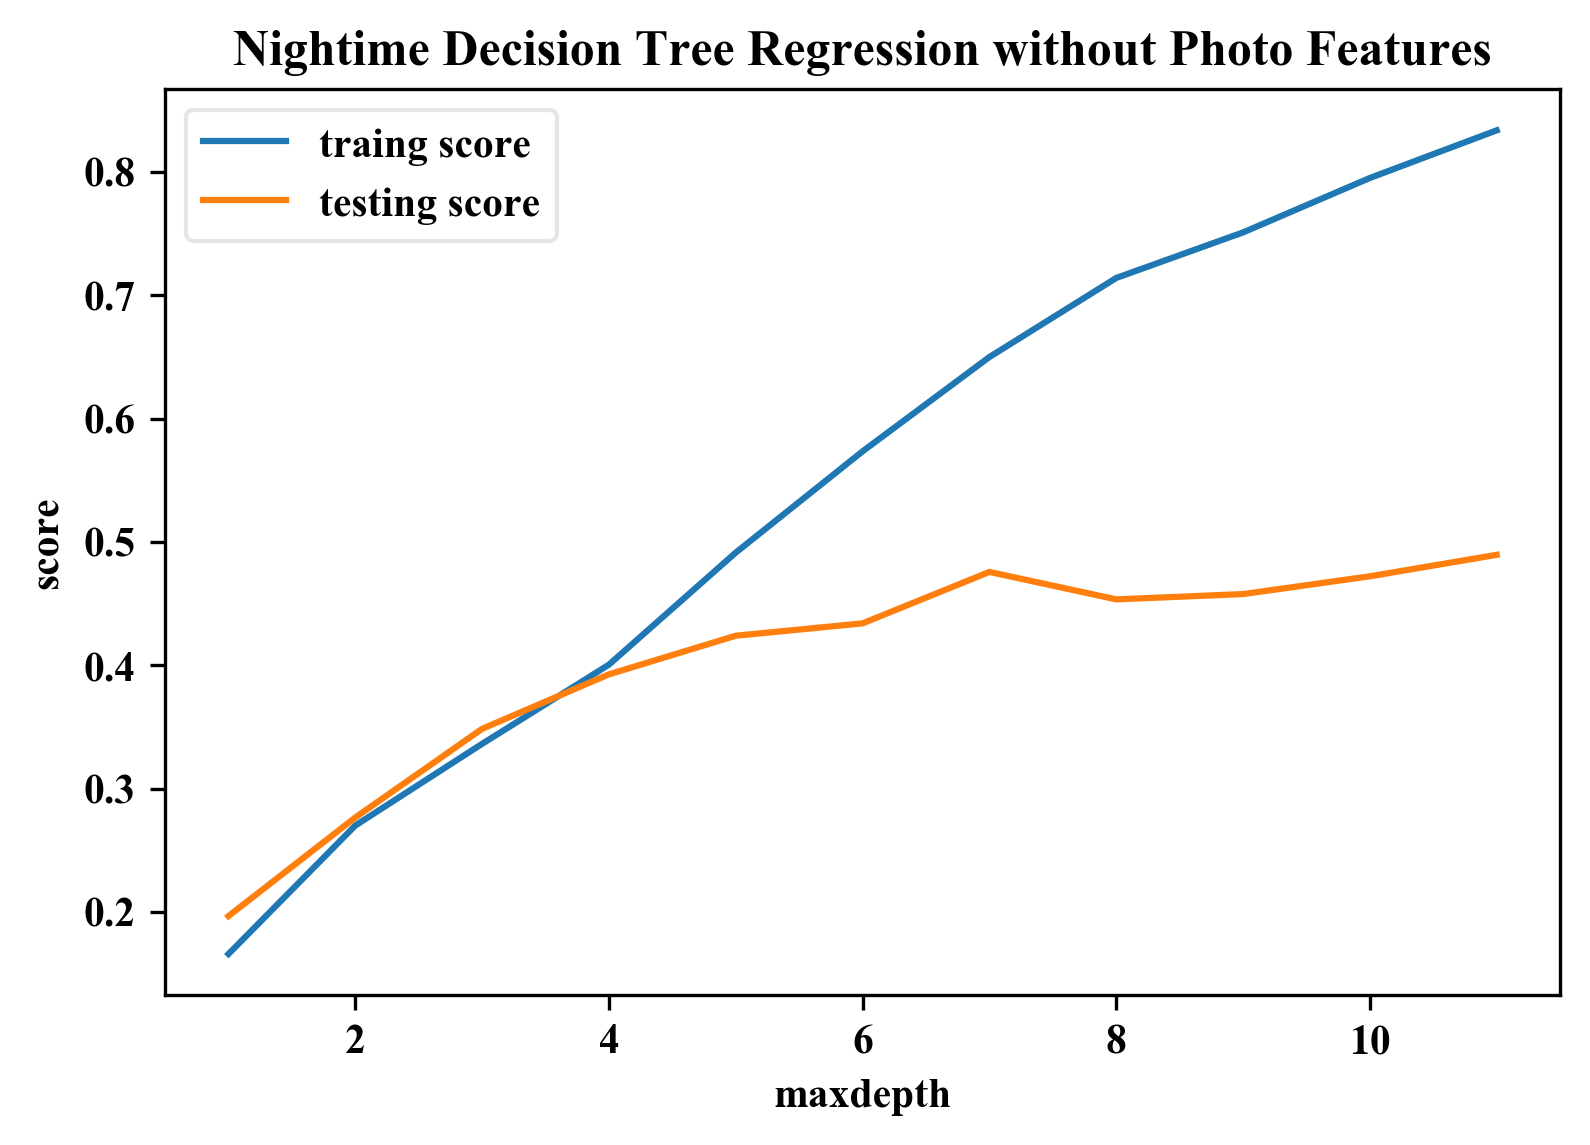

In [14]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.regression import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score

def test_DecisionTreeRegressor_depth(*data,maxdepth):
    X_train,X_test,y_train,y_test=data
    depths=np.arange(1,maxdepth)
    training_scores=[]
    testing_scores=[]
    for depth in depths:
        regr = DecisionTreeRegressor(max_depth=depth)
        regr.fit(X_train, y_train)
        training_scores.append(regr.score(X_train,y_train))
        testing_scores.append(regr.score(X_test,y_test))

    ## 绘图
    fig=plt.figure(dpi= 300)
    ax=fig.add_subplot(1,1,1)
    ax.plot(depths,training_scores,label="traing score")
    ax.plot(depths,testing_scores,label="testing score")
    ax.set_xlabel("maxdepth")
    ax.set_ylabel("score")
    ax.set_title("Nightime Decision Tree Regression without Photo Features")
    ax.legend(framealpha=0.5)
    plt.savefig('Nightime Decision Tree Regression without Photo Features.png')
    plt.show()
       
test_DecisionTreeRegressor_depth(X_train,X_test,y_train,y_test,maxdepth=12)

1789
767
MSE train: 0.325,test:0.634
0.5700059614486112 0.7963674790784274


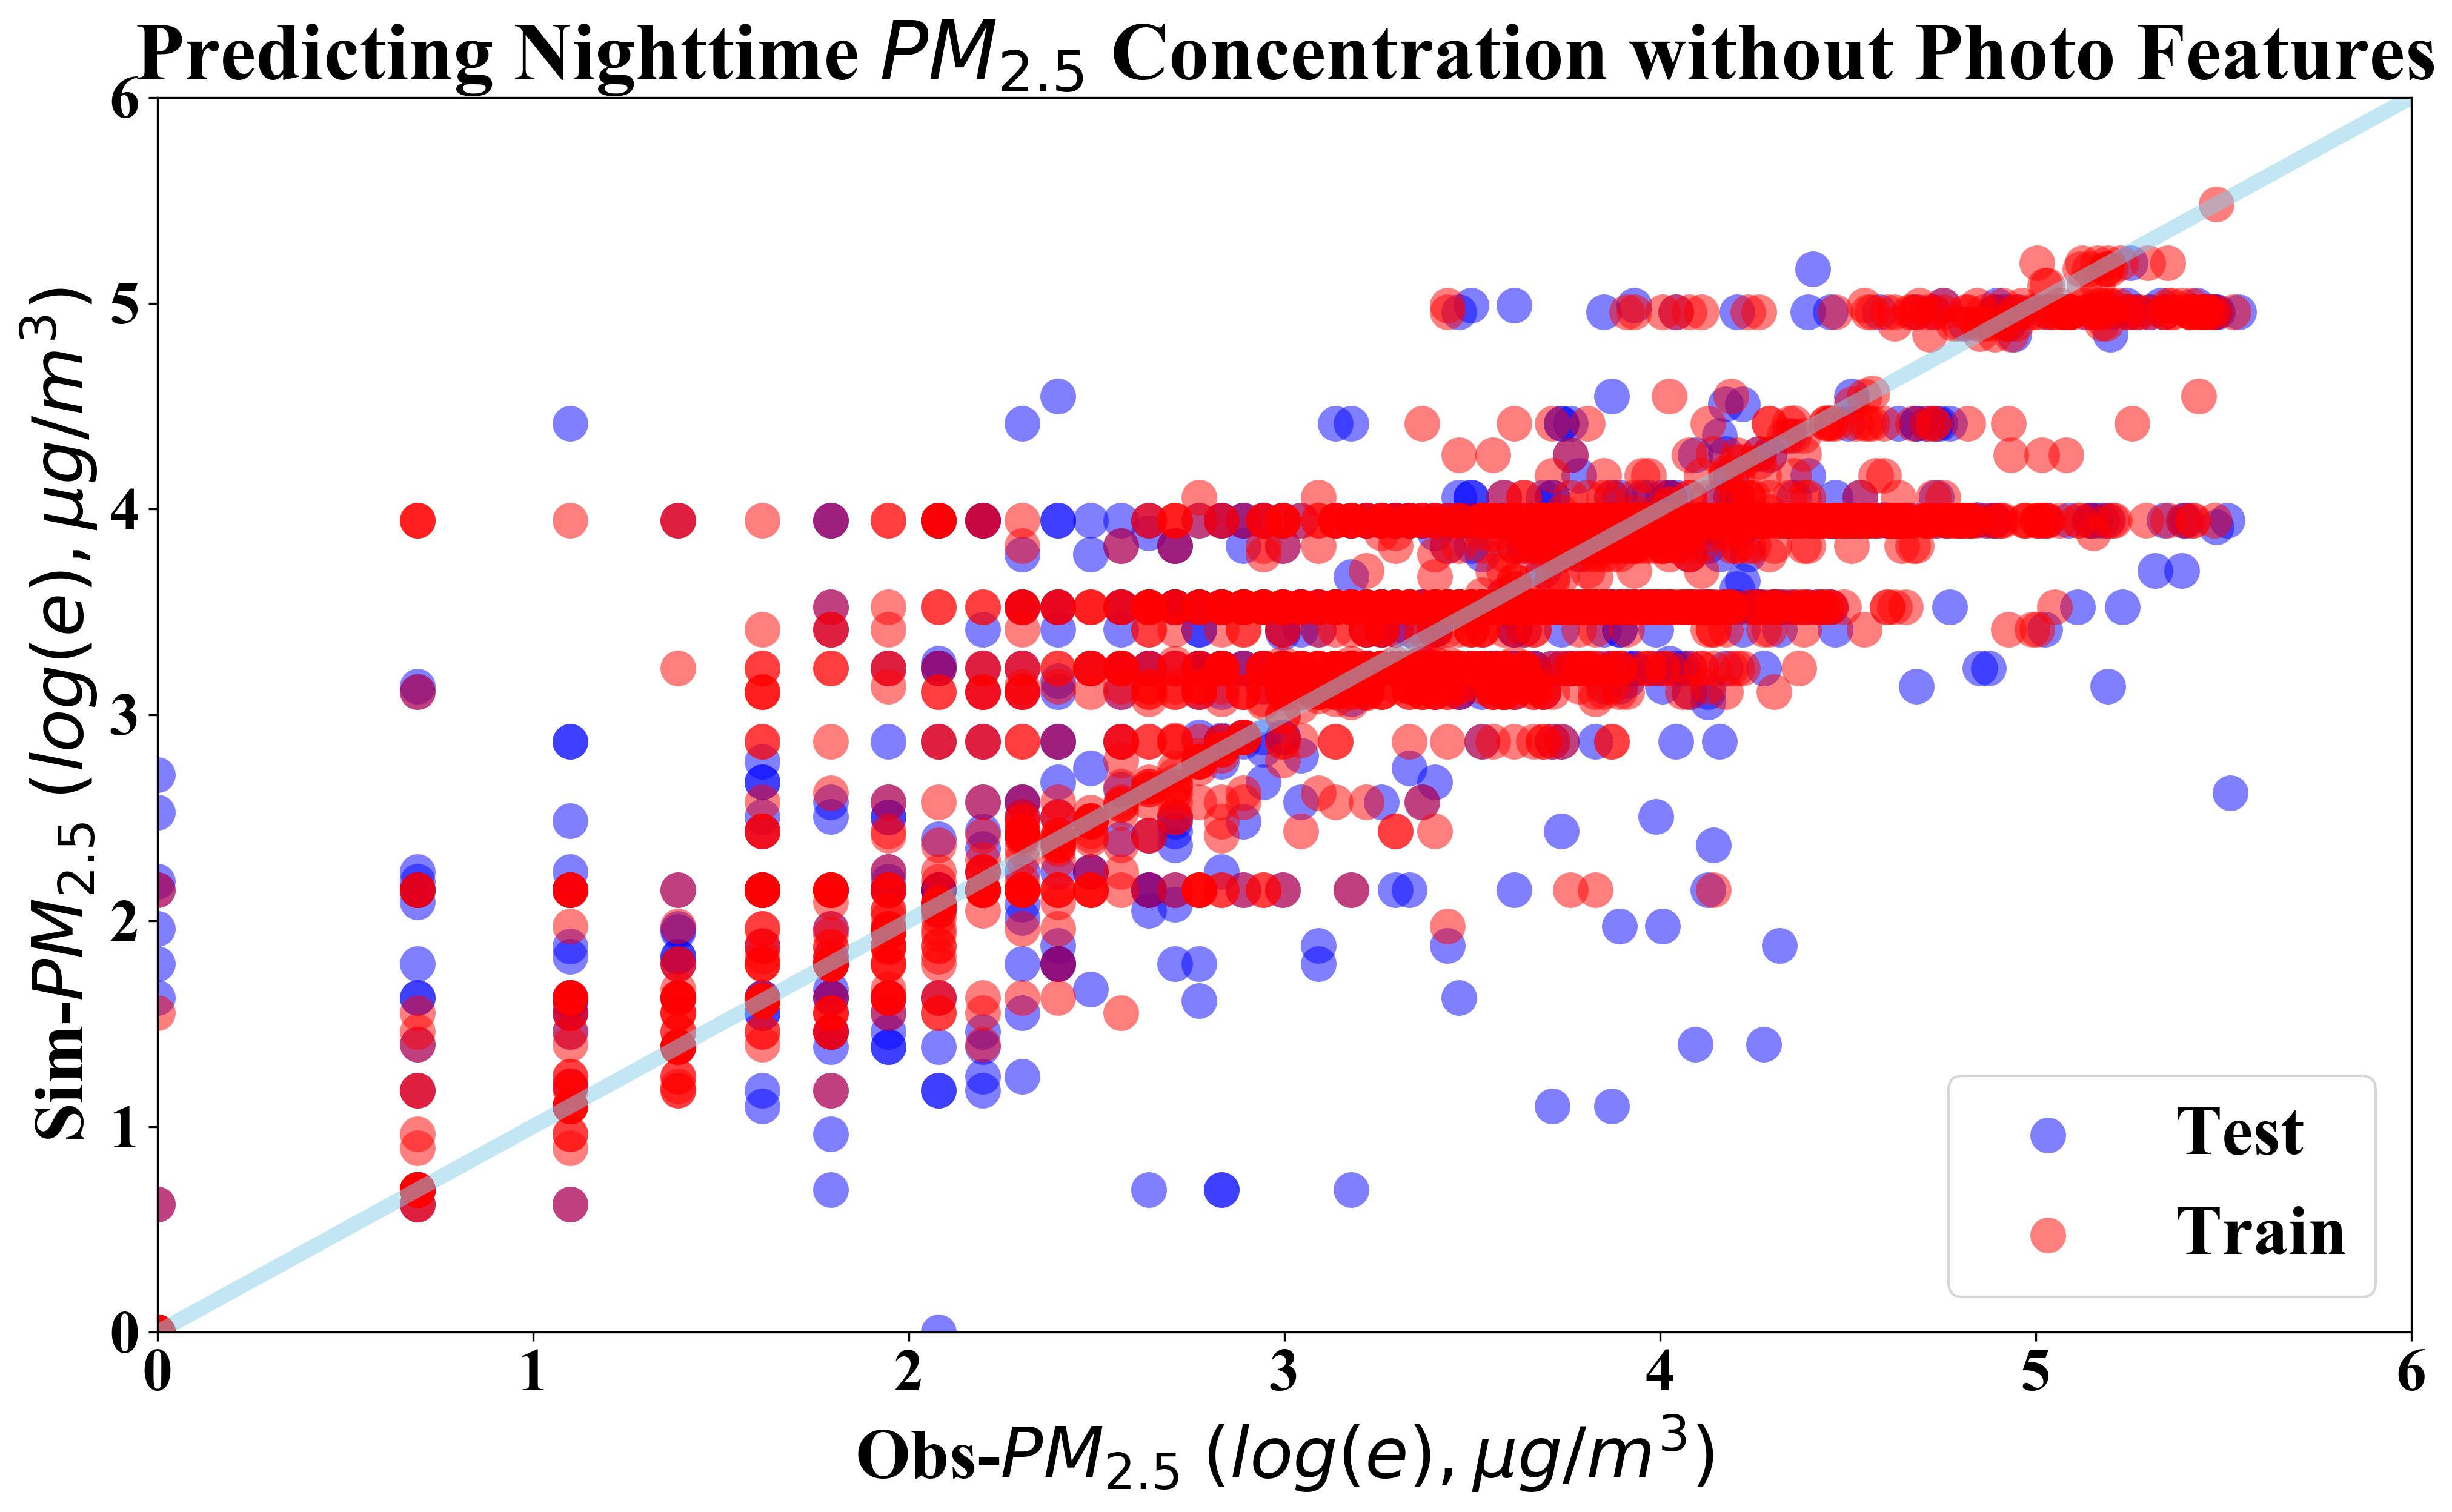

In [15]:
print(len(y_train))
print(len(y_test))
regr = DecisionTreeRegressor(max_depth=8)
regr.fit(X_train, y_train)
y = regr.predict(X_test)
y_train_pred=regr.predict(X_train)
y_pred = regr.predict(X_test)
from sklearn import metrics
print ('MSE train: %.3f,test:%.3f' % (mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_pred)))
#评估决定系数(coefficient of determination)，是MSE的标准化
#print ('R^2 train: %.3f,test:%.3f' % (r2_score(y_train,y_train_pred),r2_score(y_test,y_pred)))
RMSE_train=math.sqrt(mean_squared_error(y_train,y_train_pred))
RMSE_test=math.sqrt(mean_squared_error(y_test,y_pred))
#MSE_test_A=mean_squared_error(y_test,y_pred)
#R2_train_A=r2_score(y_train,y_train_pred)
R2_test_A=r2_score(y_test,y_pred)
print(RMSE_train,RMSE_test)
fig = plt.figure(figsize=(16,9),dpi= 300)
plt.subplot(111)
plt.tick_params(labelsize=24)
#plt.plot(Time,PMC_sim,c='blue',marker = 'o',linewidth=3,alpha=0.5,label="Simulation")
#plt.plot(Time,PMC_obs,c='red', marker = 'o',linewidth=3,alpha=0.5,label="Observation")
plt.scatter(y_test,y_pred,c='blue',s=200,marker = 'o',linewidth=0,alpha=0.5,label="Test")
plt.scatter(y_train,y_train_pred,c='red',s=200,marker = 'o',linewidth=0,alpha=0.5,label="Train")
x = np.arange(0, 400, 0.1)
y=x
plt.plot(x, y,c='skyblue',alpha=0.5,linewidth=6)
#plt.ylim(0,300)
#plt.xlim(0,300)
plt.ylim(0,6)
plt.xlim(0,6)
#plt.legend(loc="upper right",fontsize=28) #显示图中的标签
plt.xlabel('Obs-$PM_{2.5}$'+ ' '+'$ (log(e),µg/m^3)$',fontsize=28)
plt.ylabel('Sim-$PM_{2.5}$'+ ' '+'$ (log(e),µg/m^3)$',fontsize=28)
plt.legend(loc="lower right",fontsize=28)
titlestr='Predicting Nighttime $PM_{2.5}$ Concentration without Photo Features'
plt.title(titlestr,fontsize=32)
#plt.text(5,175,'Training set of model',fontsize=32)
#plt.text(5,280,'RMSE_train = 25 $ µg/m^3$',fontsize=28)
#plt.text(5,240,'RMSE_test  = 31 $ µg/m^3$',fontsize=28)
#plt.text(5,290,'Train Set = 4779 samples',fontsize=28)
#plt.text(5,260,'Test Set  = 1594 samples',fontsize=28)
plt.savefig(str(titlestr)+'.png')
plt.show()